In [ ]:
import re
import difflib
import pandas as pd

# Known universe of entities
known_universe = [
    "AKS Midco 3 Ltd.",
    "CDMA Acquisition Corp.",
    "Safety Enhancement Group, LLC",
    "Growlings Sporting Goods Company, Inc.",
    "ZDS Brands, LLC"
]

# Input list of arbitrary fund names
input_list = [
    "AKS Group",
    "CDM Acquisitionco, Inc.",
    "FA/SEG Holdings LLC (Safety Enhancement Group)",
    "Growlings Parent, Inc.",
    "ZDSP Acquisition Corp and Subsidiaries",
    "XYZ",
    "MAL Intermediate LLC"
]

# Function to clean entity names
def clean_name(name: str) -> str:
    name = name.lower()
    name = re.sub(r'[\(\)\.,]', '', name)  # remove punctuation
    # remove only legal suffixes, keep meaningful words
    name = re.sub(r'\b(inc|llc|corp|ltd|company|co)\b', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Clean known universe
cleaned_universe = {name: clean_name(name) for name in known_universe}

# Mapping function
def map_name(arbitrary_name, threshold=0.6):
    cleaned_input = clean_name(arbitrary_name)

    best_match = difflib.get_close_matches(
        cleaned_input,
        list(cleaned_universe.values()),
        n=1,
        cutoff=threshold
    )

    if best_match:
        for original, cleaned in cleaned_universe.items():
            if cleaned == best_match[0]:
                return original
    return "NA"

# Run mapping
results = {name: map_name(name) for name in input_list}

# Convert to DataFrame for display
df = pd.DataFrame(list(results.items()), columns=["Input Name", "Mapped Name"])
print(df)


                                       Input Name  \
0                                       AKS Group   
1                         CDM Acquisitionco, Inc.   
2  FA/SEG Holdings LLC (Safety Enhancement Group)   
3                          Growlings Parent, Inc.   
4          ZDSP Acquisition Corp and Subsidiaries   
5                                             XYZ   
6                            MAL Intermediate LLC   

                              Mapped Name  
0                                      NA  
1                  CDMA Acquisition Corp.  
2           Safety Enhancement Group, LLC  
3  Growlings Sporting Goods Company, Inc.  
4                                      NA  
5                                      NA  
6                                      NA  


In [ ]:
# company_matcher.py
# Requires: rapidfuzz (optional, faster). If not installed it falls back to difflib.
# pip install rapidfuzz

import re
from typing import List, Tuple

try:
    from rapidfuzz import fuzz, process
    _HAS_RAPIDFUZZ = True
except Exception:
    import difflib
    _HAS_RAPIDFUZZ = False

# List of legal suffixes / noisy tokens to strip
_SUFFIXES = [
    r"\binc\b", r"\bincorporated\b", r"\bcorp\b", r"\bcorporation\b",
    r"\bllc\b", r"\bltd\b", r"\blimited\b", r"\bplc\b",
    r"\bco\b", r"\bcompany\b", r"\bholdings\b", r"\bholding\b",
    r"\bgroup\b", r"\bpartners\b", r"\bpartner\b", r"\bsubsidiary\b",
    r"\bventures\b", r"\bventure\b", r"\bprivate\b", r"\bpvt\b",
    r"\btrust\b", r"\bfund\b", r"\bfunds\b", r"\bagency\b"
]

_STOPWORDS = [r"\bthe\b", r"\band\b", r"\b&\b", r"\bof\b", r"\bfor\b"]

_SUFFIXES_RE = re.compile("|".join(_SUFFIXES), flags=re.IGNORECASE)
_STOPWORDS_RE = re.compile("|".join(_STOPWORDS), flags=re.IGNORECASE)

def normalize_name(name: str) -> str:
    """Normalize company/fund name: lowercase, remove punctuation,
       strip suffixes/stopwords, collapse whitespace."""
    if not name:
        return ""
    s = name.lower()
    # remove punctuation except inner & (we strip & as stopword later)
    s = re.sub(r"[^\w\s]", " ", s)
    # remove common noisy suffixes and stopwords
    s = _SUFFIXES_RE.sub(" ", s)
    s = _STOPWORDS_RE.sub(" ", s)
    # collapse multiple spaces and strip
    s = re.sub(r"\s+", " ", s).strip()
    return s

def best_match(query: str, known_universe: List[str]) -> Tuple[str, float]:
    """Return (best_known_name, score). Score in 0-100."""
    qn = normalize_name(query)
    if not qn:
        return ("", 0.0)

    # Prepare normalized list mapping so we return canonical original
    normalized_map = [(name, normalize_name(name)) for name in known_universe if name]

    # RapidFuzz route (preferred)
    if _HAS_RAPIDFUZZ:
        candidates = []
        for orig, norm in normalized_map:
            score = max(
                fuzz.token_set_ratio(qn, norm),
                fuzz.partial_ratio(qn, norm),
                fuzz.ratio(qn, norm)
            )
            candidates.append((orig, score))
        best_orig, best_score = max(candidates, key=lambda x: x[1])
        return (best_orig, float(best_score))

    # difflib fallback
    else:
        best_orig, best_score = ("", 0.0)
        for orig, norm in normalized_map:
            score = difflib.SequenceMatcher(None, qn, norm).ratio() * 100.0
            if score > best_score:
                best_orig, best_score = orig, score
        return (best_orig, float(best_score))

def map_to_known(query: str, known_universe: List[str], threshold: float = 85.0) -> str:
    """Return matched canonical name or 'NA' per the rules."""
    best_orig, score = best_match(query, known_universe)
    if score >= float(threshold):
        return best_orig
    else:
        return "NA"

# Example usage
if __name__ == "__main__":
    known = [
        "Tata Consultancy Services Ltd.",
        "Reliance Industries Limited",
        "BlackRock Inc.",
        "Vanguard Group, Inc.",
        "Morgan Stanley",
        "Acme Capital Partners LLC"
    ]

    queries = [
        "Black Rock",            # variant spacing + missing punctuation
        "Vanguard Group Inc",    # suffix difference
        "Reliance Ind.",         # abbreviation
        "Acme Capital",          # parent/short name
        "Unknown Fund XYZ"       # not in known universe
    ]

    for q in queries:
        matched = map_to_known(q, known, threshold=80.0)
        print(f"Query: {q}  =>  {matched}")


Query: Black Rock  =>  BlackRock Inc.
Query: Vanguard Group Inc  =>  Vanguard Group, Inc.
Query: Reliance Ind.  =>  NA
Query: Acme Capital  =>  Acme Capital Partners LLC
Query: Unknown Fund XYZ  =>  NA


In [ ]:
import re

# Step 1: Normalize fund names (remove suffixes, punctuation, case differences)
def normalize_name(name: str) -> str:
    name = name.lower()
    name = re.sub(r'\b(inc|llc|corp|company|ltd|holdings?|subsidiaries|parent)\b', '', name)
    name = re.sub(r'[^a-z0-9 ]', '', name)   # remove non-alphanumeric
    return " ".join(name.split())            # remove extra spaces

# Step 2: Match arbitrary name against known universe
def match_fund_name(arbitrary_name: str, known_universe: list[str]) -> str:
    norm_input = normalize_name(arbitrary_name)
    for known in known_universe:
        if normalize_name(known) == norm_input:
            return known   # return original known universe name
    return "NA"

# Example usage
known_universe = [
    "BlackRock Fund Advisors, Inc.",
    "Vanguard Group LLC",
    "State Street Corporation"
]

print(match_fund_name("BlackRock Fund Advisors", known_universe))   # ✅ BlackRock Fund Advisors, Inc.
print(match_fund_name("Vanguard Group", known_universe))            # ✅ Vanguard Group LLC
print(match_fund_name("Random Capital", known_universe))            # ❌ NA


BlackRock Fund Advisors, Inc.
Vanguard Group LLC
NA


In [ ]:
import re
import pandas as pd

# Step 1: Normalize names (remove suffixes, punctuation, case)
def normalize_name(name: str) -> str:
    name = name.lower()
    # Remove legal suffixes (similar to R's gsub)
    name = re.sub(r'\b(inc|inc\.|llc|corp|corporation|company|co\.|ltd|holdings?|subsidiaries|parent)\b', '', name)
    # Remove non-alphanumeric
    name = re.sub(r'[^a-z0-9 ]', '', name)
    # Remove extra spaces
    return " ".join(name.split())

# Step 2: Match arbitrary fund name to known universe
def match_fund_name(arbitrary_name: str, known_universe: list[str]) -> str:
    norm_input = normalize_name(arbitrary_name)
    for known in known_universe:
        if normalize_name(known) == norm_input:
            return known   # return matched known universe entity
    return "NA"

# Example known universe (entity master list)
known_universe = [
    "BlackRock Fund Advisors, Inc.",
    "Vanguard Group LLC",
    "State Street Corporation"
]

# Example test dataset
test_names = [
    "BlackRock Fund Advisors",
    "Vanguard Group",
    "Random Capital",
    "State Street Corp"
]

# Map results into a DataFrame (like in R data.frame)
df = pd.DataFrame({
    "Input Name": test_names,
    "Matched Entity": [match_fund_name(name, known_universe) for name in test_names]
})

print(df)


                Input Name                 Matched Entity
0  BlackRock Fund Advisors  BlackRock Fund Advisors, Inc.
1           Vanguard Group             Vanguard Group LLC
2           Random Capital                             NA
3        State Street Corp       State Street Corporation


In [ ]:
import re
import difflib
import pandas as pd

known_universe = [
    "AKS Midco 3 Ltd.",
    "CDMA Acquisition Corp.",
    "Safety Enhancement Group, LLC",
    "Growlings Sporting Goods Company, Inc.",
    "ZDS Brands, LLC"
]

input_list = [
    "AKS Group",
    "CDM Acquisitionco, Inc.",
    "FA/SEG Holdings LLC (Safety Enhancement Group)",
    "Growlings Parent, Inc.",
    "ZDSP Acquisition Corp and Subsidiaries",
    "XYZ",
    "MAL Intermediate LLC"
]

def clean_name(name):
    name = name.lower()
    name = re.sub(r'[\\(\\)\\.,]', '', name)
    name = re.sub(r'\\b(inc|llc|corp|ltd|company|co|holdings|group|parent|subsidiaries)\\b', '', name)
    name = re.sub(r'\\s+', ' ', name).strip()
    return name

cleaned_universe = {name: clean_name(name) for name in known_universe}

def map_name(arbitrary_name, threshold=0.75):
    cleaned_input = clean_name(arbitrary_name)

    best_match = difflib.get_close_matches(
        cleaned_input,
        list(cleaned_universe.values()),
        n=1,
        cutoff=threshold
    )

    if best_match:

        for original, cleaned in cleaned_universe.items():
            if cleaned == best_match[0]:
                return original
    return "NA"
results = {name: map_name(name) for name in input_list}

df = pd.DataFrame(list(results.items()), columns=["Input Name", "Mapped Name"])
print(df)

                                       Input Name             Mapped Name
0                                       AKS Group                      NA
1                         CDM Acquisitionco, Inc.  CDMA Acquisition Corp.
2  FA/SEG Holdings LLC (Safety Enhancement Group)                      NA
3                          Growlings Parent, Inc.                      NA
4          ZDSP Acquisition Corp and Subsidiaries                      NA
5                                             XYZ                      NA
6                            MAL Intermediate LLC                      NA


In [ ]:
import sys

import matplotlib

matplotlib.use('Agg')

import matplotlib.pyplot as plt

x = [5,7,8,7,2,17,2,9,4,11,12,9,6]

y = [99,86,87,88,111,86,103,87,94,78,77,85,86]

plt.scattery()
plt.savefig(ys. _stdout_.buffer)
sys._stdout_.flush()

AttributeError: module 'matplotlib.pyplot' has no attribute 'scattery'

In [ ]:
import sys
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

# import matplotlib.pyplot as plt

x = [5,7,8,7,2,17,2,9,4,11,12,9,6]
y = [99,86,87,88,111,86,103,87,94,78,77,85,86]

plt.scatter(x, y)

# plt.savefig(sys.stdout.buffer) # This caused the error
# sys.stdout.flush() # This is also not needed

# Save the figure to a file instead
plt.savefig('scatter_plot.png')

# Display the plot directly in Colab
plt.show()

In [ ]:
import sys
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

# import matplotlib.pyplot as plt

x = [5,7,8,7,2,17,2,9,4,11,12,9,6]
y = [99,86,87,88,111,86,103,87,94,78,77,85,86]

plt.scatter(x, y)

# plt.savefig(sys.stdout.buffer) # This caused the error
# sys.stdout.flush() # This is also not needed

# Save the figure to a file instead
plt.savefig('scatter_plot.png')

# Display the plot directly in Colab
plt.show()

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
x,y = iris.data, iris.target

model = SVC (kernel="linear", random_state=42)

#define the number of folds for k-fold cross-validation
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")

#print the results
print (f"Cross-validation scores for each fold: {scores}")

print (f"Mean accuracy: {np.mean(scores):.4f}")

print(f"Standard deviation of accuracy: {np.std(scores):.4f}")

Cross-validation scores for each fold: [1.         1.         0.96666667 0.93333333 0.96666667]
Mean accuracy: 0.9733
Standard deviation of accuracy: 0.0249


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


False Positive Rates: [0.         0.         0.         0.01587302 0.01587302 0.07936508
 0.07936508 1.        ]
True Positive Rates: [0.         0.00925926 0.93518519 0.93518519 0.98148148 0.98148148
 1.         1.        ]
AUC Score: 0.9977954144620812


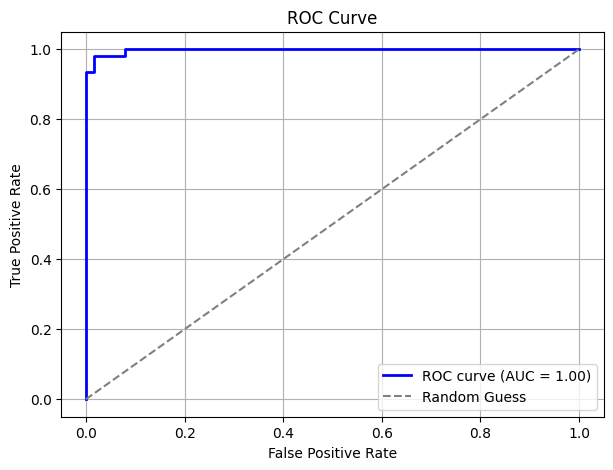

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

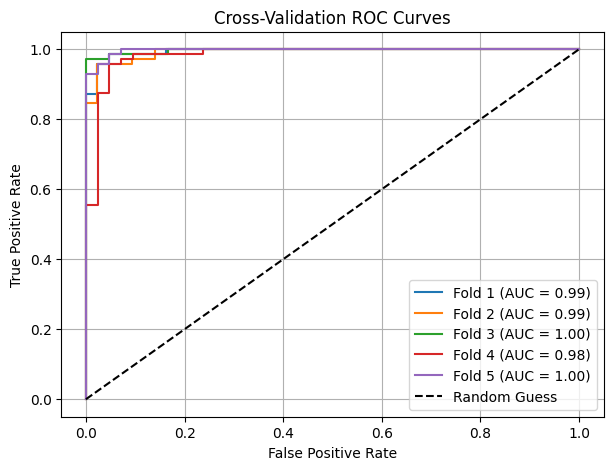

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print values
print("False Positive Rates:", fpr)
print("True Positive Rates:", tpr)
print("AUC Score:", roc_auc)

# ----- GRAPH OUTPUT -----
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay

X, y = load_breast_cancer(return_X_y=True)
model = LogisticRegression(max_iter=200)
cv = StratifiedKFold(n_splits=5)

plt.figure(figsize=(7,5))

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict_proba(X[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y[test_idx], y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Cross-Validation ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


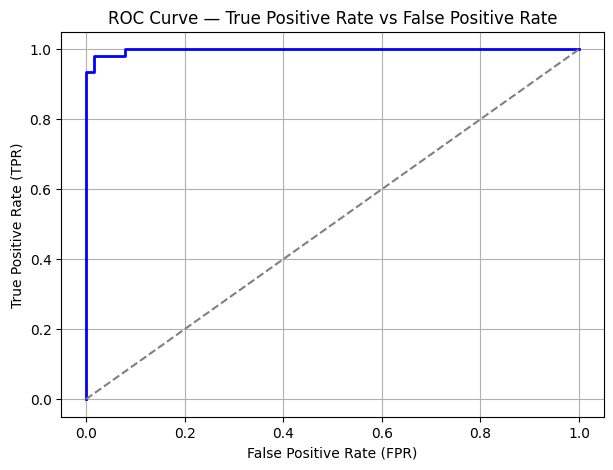

Thresholds: [           inf 9.99997384e-01 8.43928859e-01 8.36620471e-01
 7.19991846e-01 3.49272469e-01 2.38938695e-01 6.20720053e-28]
FPR (False Positive Rate): [0.         0.         0.         0.01587302 0.01587302 0.07936508
 0.07936508 1.        ]
TPR (True Positive Rate): [0.         0.00925926 0.93518519 0.93518519 0.98148148 0.98148148
 1.         1.        ]
AUC Score (using roc_auc_score): 0.998
AUC Score (using auc() integration): 0.998


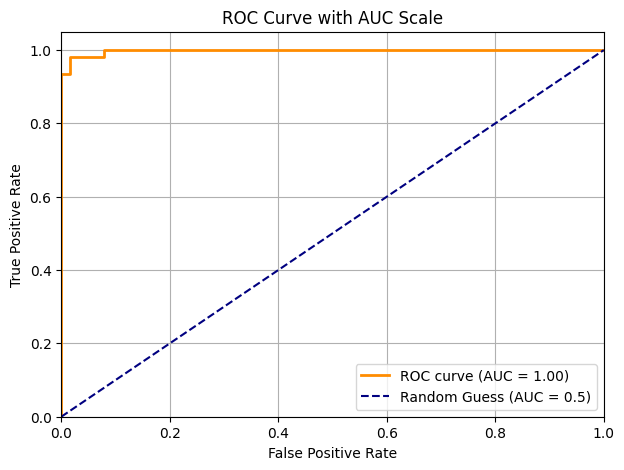

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

# Load dataset
X, y = load_breast_cancer(return_X_y=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Get predicted probabilities (for positive class)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# ----- PLOT ROC CURVE -----
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random guess line
plt.title("ROC Curve — True Positive Rate vs False Positive Rate")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.grid(True)
plt.show()

# Show sample threshold values
print("Thresholds:", thresholds[:10])  # show first 10 thresholds
print("FPR (False Positive Rate):", fpr[:10])
print("TPR (True Positive Rate):", tpr[:10])
from sklearn.metrics import roc_auc_score, auc

# Compute AUC using sklearn
roc_auc = roc_auc_score(y_test, y_pred_prob)

# (Alternative method using fpr/tpr)
roc_auc_from_curve = auc(fpr, tpr)

print(f"AUC Score (using roc_auc_score): {roc_auc:.3f}")
print(f"AUC Score (using auc() integration): {roc_auc_from_curve:.3f}")

# ----- PLOT AUC SCALE -----
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC Scale')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


AUC Score (using roc_auc_score): 0.998
AUC Score (using auc() integration): 0.998


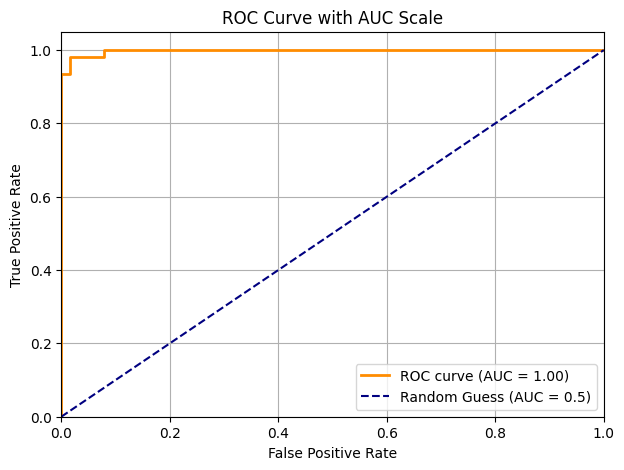

In [ ]:
from sklearn.metrics import roc_auc_score, auc

# Compute AUC using sklearn
roc_auc = roc_auc_score(y_test, y_pred_prob)

# (Alternative method using fpr/tpr)
roc_auc_from_curve = auc(fpr, tpr)

print(f"AUC Score (using roc_auc_score): {roc_auc:.3f}")
print(f"AUC Score (using auc() integration): {roc_auc_from_curve:.3f}")

# ----- PLOT AUC SCALE -----
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC Scale')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC (roc_auc_score): 0.998
AUC (from auc integration): 0.998
FPR (False Positive Rate): [0.         0.         0.         0.01587302 0.01587302]
TPR (True Positive Rate): [0.         0.00925926 0.93518519 0.93518519 0.98148148]
Thresholds: [       inf 0.99999738 0.84392886 0.83662047 0.71999185]


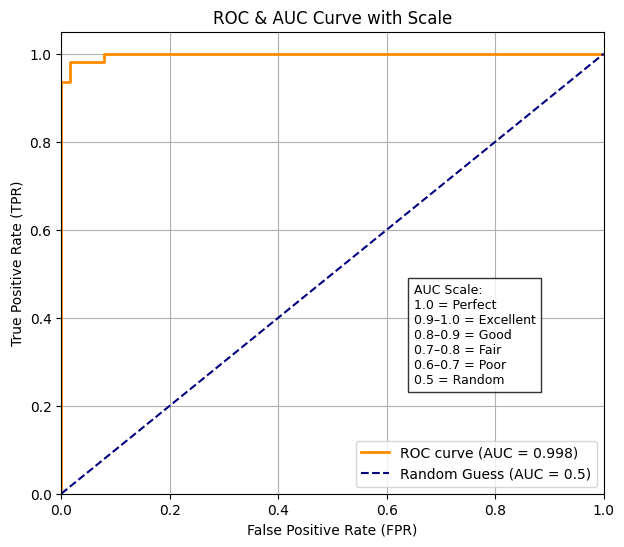

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

# -----------------------------
# STEP 1: Load dataset
# -----------------------------
X, y = load_breast_cancer(return_X_y=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------
# STEP 2: Train the model
# -----------------------------
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# -----------------------------
# STEP 3: Predict probabilities
# -----------------------------
y_pred_prob = model.predict_proba(X_test)[:, 1]

# -----------------------------
# STEP 4: Compute ROC & AUC
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)   # AUC value
roc_auc_calc = auc(fpr, tpr)                   # AUC from curve integration

# -----------------------------
# STEP 5: Print key metrics
# -----------------------------
print(f"AUC (roc_auc_score): {roc_auc:.3f}")
print(f"AUC (from auc integration): {roc_auc_calc:.3f}")
print("FPR (False Positive Rate):", fpr[:5])
print("TPR (True Positive Rate):", tpr[:5])
print("Thresholds:", thresholds[:5])

# -----------------------------
# STEP 6: Plot ROC + AUC scale
# -----------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess (AUC = 0.5)')

# Scale / labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC & AUC Curve with Scale')
plt.legend(loc="lower right")
plt.grid(True)

# Add AUC scale text
plt.text(0.65, 0.25, f'AUC Scale:\n1.0 = Perfect\n0.9–1.0 = Excellent\n0.8–0.9 = Good\n0.7–0.8 = Fair\n0.6–0.7 = Poor\n0.5 = Random',
         bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

plt.show()


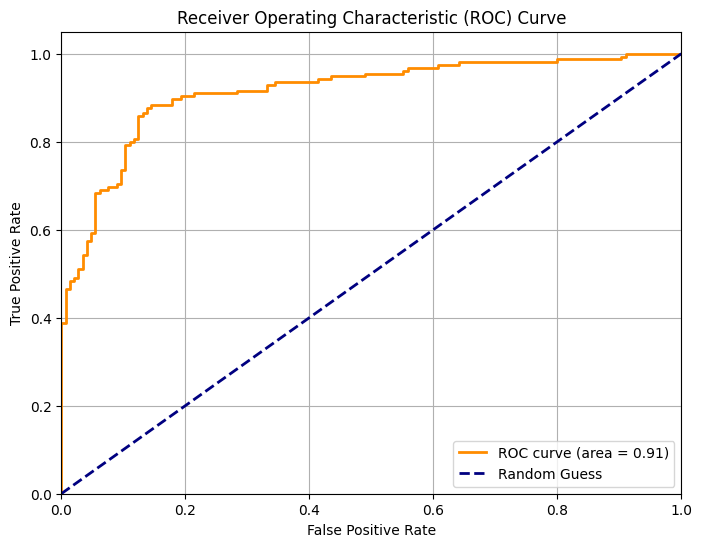

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color="darkorange", lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend(loc="lower right")

plt.grid(True)

plt.show()

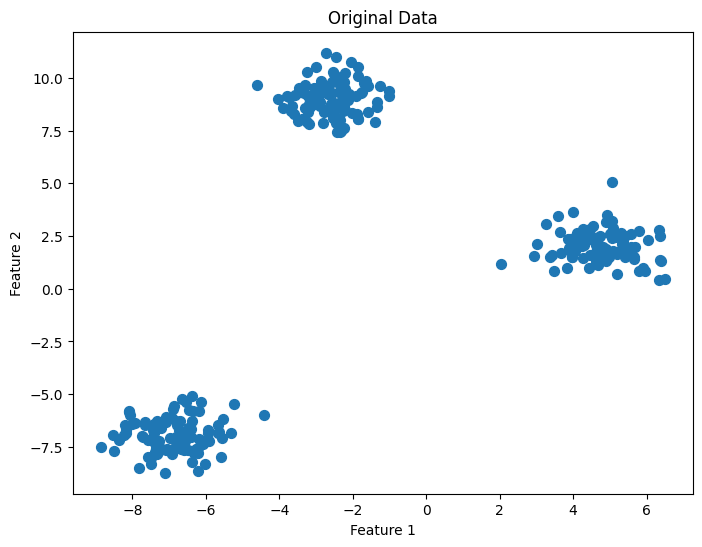

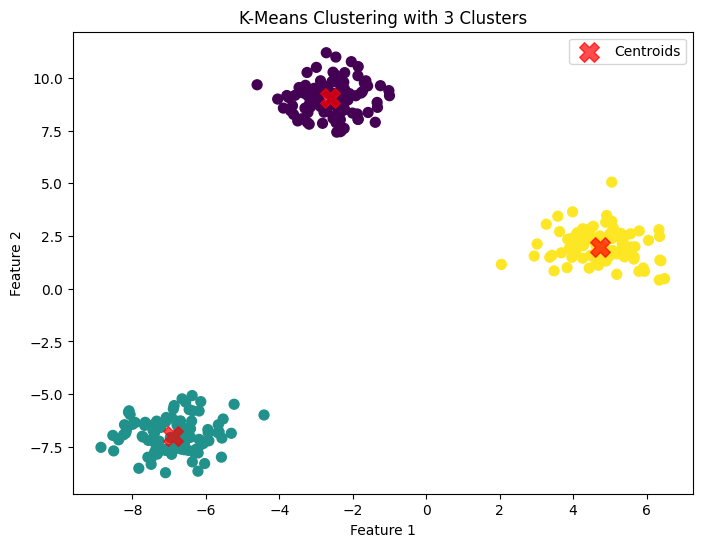

Inertia (Sum of squared distances of samples to their closest cluster center): 362.7901127196245


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=0.8)

# Plot original data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Perform K-Means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X)

# Get labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot clustered data and centroids
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.7, marker='X', label='Centroids')
plt.title(f"K-Means Clustering with {n_clusters} Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Print inertia
print(f"Inertia (Sum of squared distances of samples to their closest cluster center): {kmeans.inertia_}")

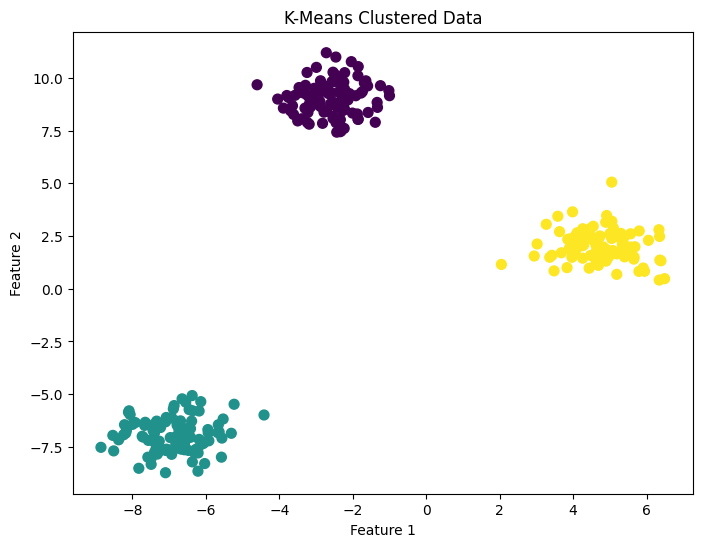

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Use data and labels from the previous cell
# Assuming X and labels are available from the previous cell execution
# If not, you would need to regenerate or load your data here
# X, _ = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=0.8)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# kmeans.fit(X)
# labels = kmeans.labels_

# Plot clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis') # Use X and labels for plotting
plt.title("K-Means Clustered Data") # Corrected typo and added a title
plt.xlabel("Feature 1") # Using generic labels as variable names were undefined
plt.ylabel("Feature 2") # Using generic labels as variable names were undefined
plt.show() # Corrected function call

# The variables alpha, monsoon, beta, and gama were not defined and are not used in this corrected code.
# The line [plt,show] is not valid Python code.

Predicted Salary for 7 years of experience: 46733.33333333334


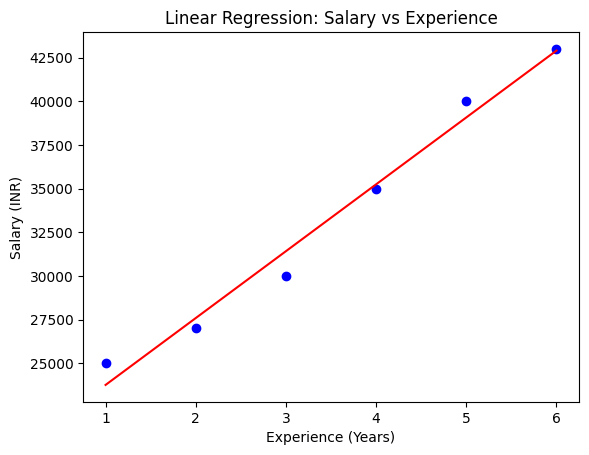

In [ ]:
# Linear Regression Example
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Training Data
experience = np.array([1, 2, 3, 4, 5, 6]).reshape(-1, 1)
salary = np.array([25000, 27000, 30000, 35000, 40000, 43000])

# Model
model = LinearRegression()
model.fit(experience, salary)

# Prediction
predicted_salary = model.predict([[7]])
print("Predicted Salary for 7 years of experience:", predicted_salary[0])

# Graph
plt.scatter(experience, salary, color='blue')
plt.plot(experience, model.predict(experience), color='red')
plt.title("Linear Regression: Salary vs Experience")
plt.xlabel("Experience (Years)")
plt.ylabel("Salary (INR)")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data
X = [[60], [70], [80], [90], [50], [40], [30]]  # performance score
y = [0, 0, 1, 1, 0, 0, 0]  # 1 = promoted, 0 = not promoted

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Predicted promotion status:", model.predict([[85]]))  # Example prediction


Accuracy: 0.6666666666666666
Predicted promotion status: [1]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Sample Dataset
data = {
    'Experience': [1, 3, 5, 7, 9],
    'Age': [22, 25, 28, 32, 36],
    'Education_Level': [1, 2, 2, 3, 3],  # 1=UG, 2=PG, 3=PhD
    'Salary': [25000, 35000, 50000, 65000, 80000]
}
df = pd.DataFrame(data)

# Split
X = df[['Experience', 'Age', 'Education_Level']]
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)
print("Predicted Salaries:", pred)


Predicted Salaries: [37500.]


Predicted Salary for 7 years of experience (Polynomial): 96000.00000000003


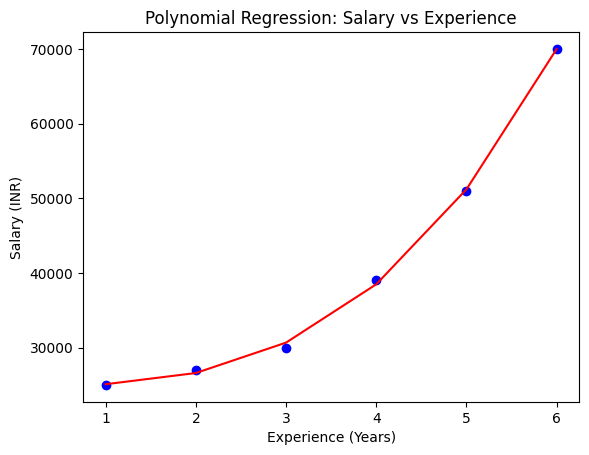

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Data
X = np.array([1, 2, 3, 4, 5, 6]).reshape(-1, 1)
y = np.array([25000, 27000, 30000, 39000, 51000, 70000])

# Polynomial Transform
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Model
model = LinearRegression()
model.fit(X_poly, y)

# Prediction
pred = model.predict(poly.transform([[7]]))
print("Predicted Salary for 7 years of experience (Polynomial):", pred[0])

# Graph
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X_poly), color='red')
plt.title("Polynomial Regression: Salary vs Experience")
plt.xlabel("Experience (Years)")
plt.ylabel("Salary (INR)")
plt.show()


Predicted Cargo Volume for 2025: 129.73169577121735 Million Tons


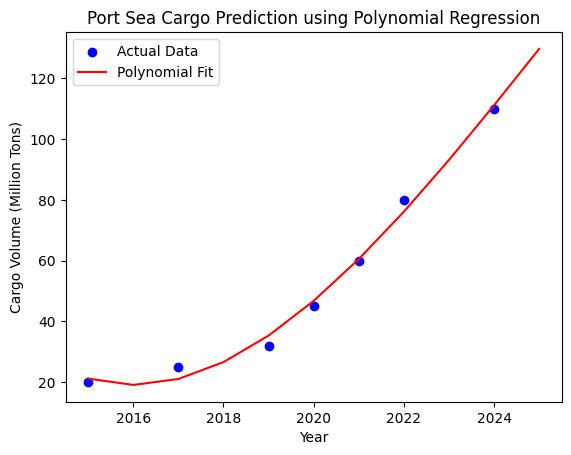

In [ ]:
# 📦 Port Sea Cargo Prediction using Polynomial Regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Sample Data (Year vs Cargo Volume in Million Tons)
year = np.array([2015, 2017, 2019, 2020, 2021, 2022, 2024]).reshape(-1, 1) # Removed 2025 to match cargo_volume length
cargo_volume = np.array([20, 25, 32, 45, 60, 80, 110])  # non-linear increase

# Convert to Polynomial Features
poly = PolynomialFeatures(degree=3)
year_poly = poly.fit_transform(year)

# Train the Model
model = LinearRegression()
model.fit(year_poly, cargo_volume)

# Predict Future (e.g., 2025)
future_year = np.array([[2025]])
future_year_poly = poly.transform(future_year)
predicted_cargo = model.predict(future_year_poly)
print("Predicted Cargo Volume for 2025:", predicted_cargo[0], "Million Tons")

# Graph
plt.scatter(year, cargo_volume, color='blue', label="Actual Data")
# Create a range of years for plotting the fitted curve
years_for_plot = np.arange(year.min(), future_year.max() + 1).reshape(-1, 1)
years_for_plot_poly = poly.transform(years_for_plot)
plt.plot(years_for_plot, model.predict(years_for_plot_poly), color='red', label="Polynomial Fit")

plt.xlabel("Year")
plt.ylabel("Cargo Volume (Million Tons)")
plt.title("Port Sea Cargo Prediction using Polynomial Regression")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    # 1️⃣ Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),

    # 2️⃣ Pooling Layer
    MaxPooling2D(pool_size=(2, 2)),

    # 3️⃣ Second Convolution
    Conv2D(64, (3, 3), activation='relu'),

    # 4️⃣ Flatten + Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,889,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,909,121 (26.36 MB)

 Trainable params: 6,909,121 (26.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),   # Fully connected layer
    Dense(10, activation='softmax')  # Output layer (10 classes)
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,938,570 (15.02 MB)

 Trainable params: 3,938,570 (15.02 MB)

 Non-trainable params: 0 (0.00 B)